In [1]:
# Very intentionally construct input matrices myself - this ensures that the matrices are what I mean them to be.
# Can be effectively replaced with scikit-learn preprocessing methods.

# TODO: rename the onehot dicts to feature dicts

import os, sys, glob
import numpy as np
import scipy as sp
import copy
#import keras
import itertools as it

def pad_to_dimensions(array, dimensions):
    # Return a right-padded N-dimensional array to the specified dimensions
    # If a dimension is None, then padding is not done for that dimensions
    assert type(dimensions) == tuple, 'Dimensions must be a tuple.'
    assert len(array.shape) == len(dimensions), 'Mismatch between array dimension and number of dimensions provided.'
    pad_lengths = [requestDim - arrDim if requestDim != None else arrDim for arrDim, requestDim in zip(array.shape, dimensions)]
    assert all(i>=0 for i in pad_lengths), 'Array larger than provided dimensions.'
    pad_lengths_formatted = [(0, pad_length) for pad_length in pad_lengths]
    return np.pad(array, pad_lengths_formatted, mode='constant', constant_values=0)

def gen_onehot_dict_default(cohort):
    # Return an int -> vector map for each unique element in cohort of arrays
    # TODO: Should you zero out the case when an entry is 0, at least for the graph matrices???
    def genVector(entryNum, numEntries):
        onehot_vec = np.zeros((numEntries,))
        onehot_vec[entryNum] = 1
        return onehot_vec
    uniqueEntries = np.unique(np.concatenate([np.unique(array) for array in cohort]))
    numUniques = len(uniqueEntries)
    return {uniqueEntry: genVector(idx, numUniques) for idx, uniqueEntry in enumerate(uniqueEntries)}

def standardize_array_shapes(arrays):
    # Pad arrays to the same size
    array_shapes = [array.shape for array in arrays]
    dims = tuple([max(lengths) for lengths in zip(*[np.shape(array) for array in arrays])])
    return [pad_to_dimensions(array, dims) for array in arrays]
    
def make_onehot(cohort, onehot_dict=None, verbose=False):
    # Makes a cohort of arrays onehot, then pads arrays to the same size.
    # Returns (onehot dictionary, arrays)

    def gen_onehot(array, onehot_dict):
        # Should be parallelized for better performance
        extension_length = len(onehot_dict.values()[0])
        new_dims = tuple(list(array.shape) + [extension_length])
        onehot_array = np.zeros(new_dims)
        for index in np.ndindex(array.shape):
            onehot_index_full = tuple(list(index) + [None]) # Slice whole remaining dimension
            onehot_array[onehot_index_full] = onehot_dict[array[index]]
        return onehot_array

    if onehot_dict == None:
        onehot_dict = gen_onehot_dict_default(cohort)
    onehot_cohort = [gen_onehot(array, onehot_dict) for array in cohort]
    return onehot_dict, onehot_cohort

def readgraph(fname):
    # Returns a header/IntArray and matrix/IntArray. Assert header and matrix have same length.
    a = open(fname); b = a.readlines(); a.close()
    csv_as_float_2D = [map(float,i.strip().split(',')) for i in b]
    header = np.array(csv_as_float_2D[0])
    matrix = np.array(csv_as_float_2D[1:])
    return {'header':header, 'matrix':matrix}

def standardize_graphs(graphs, max_size=None, verbose=True):
    # Graphs is an iterable of dictionaries {'header': header, 'matrix': matrix}
    # Take in a N-length atom list, NxN matrix, assert all entries are in one-hot dictionaries
    if max_size == None:
        max_size = max(len(graph['header']) for graph in graphs)
        
    kept_graphs = [graph for graph in graphs if len(graph['header']) <= max_size]
    assert len(kept_graphs) > 0, 'No graphs are smaller than the provided max size'
    headers = [i['header'] for i in kept_graphs]
    matrices = [i['matrix'] for i in kept_graphs]
    headers_padded = standardize_array_shapes(headers)
    matrices_padded = standardize_array_shapes(matrices)
    connectivities = [(i!=0).astype(float) for i in matrices_padded]

    headers_onehot_dict, headers_new = make_onehot(headers_padded)
    matrices_onehot_dict, matrices_new = make_onehot(matrices_padded)
    
    outputGraphs = [{'header': header, 'matrix': matrix, 'connectivity': connectivity, 'origHeader': origHeader, 'origMatrix': origMatrix}
                    for header,matrix,connectivity,origHeader,origMatrix
                    in zip(headers_new, matrices_new, connectivities,headers_padded,matrices_padded)]
    
    if verbose:
        print 'Header One-Hot Map:', headers_onehot_dict
        print 'Bond One-Hot Map:', matrices_onehot_dict
        print 'Graph Size:', max_size
        print 'Number of dropped graphs:', len(graphs) - len(kept_graphs)
        
    return headers_onehot_dict, matrices_onehot_dict, outputGraphs

# Read in graphs
graph_files = glob.glob('qm9graph/*.csv')
mygraphs = [readgraph(fname) for fname in graph_files]
headers_onehot_dict, matrices_onehot_dict, mygraphs_standardized = standardize_graphs(mygraphs, max_size=29)
headers_padded = np.array([i['header'] for i in mygraphs_standardized])
matrices_padded = np.array([i['matrix'] for i in mygraphs_standardized])
connectivities_padded = np.array([i['connectivity'] for i in mygraphs_standardized])
origHeaders_padded = np.array([i['origHeader'] for i in mygraphs_standardized])
origMatrices_padded = np.array([i['origMatrix'] for i in mygraphs_standardized])
print headers_padded.shape
print matrices_padded.shape
print connectivities_padded.shape

Header One-Hot Map: {0.0: array([1., 0., 0., 0., 0., 0.]), 1.0: array([0., 1., 0., 0., 0., 0.]), 6.0: array([0., 0., 1., 0., 0., 0.]), 7.0: array([0., 0., 0., 1., 0., 0.]), 8.0: array([0., 0., 0., 0., 1., 0.]), 9.0: array([0., 0., 0., 0., 0., 1.])}
Bond One-Hot Map: {0.0: array([1., 0., 0., 0.]), 1.0: array([0., 1., 0., 0.]), 2.0: array([0., 0., 1., 0.]), 3.0: array([0., 0., 0., 1.])}
Graph Size: 29
Number of dropped graphs: 0
(665, 29, 6)
(665, 29, 29, 4)
(665, 29, 29)


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Need if Conda environment isn't resolved properly
import keras
import sklearn.model_selection
import keras.backend as K

def stacker(tensorList):
    # Stack the bond hidden vectors and atom hidden vectors (29x29x(2*size(atom hidden) + size(bond_hidden)))
    bond_hiddens = tensorList[0]
    atom_hiddens = tensorList[1]
    vertical_atom_hiddens = keras.backend.expand_dims(atom_hiddens,axis=2)
    vertical_atom_hiddens_horizontal = keras.backend.repeat_elements(vertical_atom_hiddens,29,2)
    horiz_atom_hiddens = keras.backend.expand_dims(atom_hiddens,axis=1)
    horiz_atom_hiddens_vertical = keras.backend.repeat_elements(horiz_atom_hiddens,29,1)
    
    big_hidden_boi = keras.backend.concatenate([vertical_atom_hiddens_horizontal, horiz_atom_hiddens_vertical, bond_hiddens], axis=3)
    return big_hidden_boi

def summer(tensorList):
    # Sums the message matrix (29x29x(size(message)))
    messages = tensorList[0]
    connectivity = tensorList[1]
    # Zero out all unconnected messages
    connectivity_expanded = keras.backend.expand_dims(connectivity, axis=3)
    # Add all messages horizontally (29xsize(message))
    filtered = messages*connectivity_expanded # note: * is element-wise, keras.dot is matrix multiplication
    summed_horiz = keras.backend.sum(filtered, axis=2)
    return summed_horiz

def generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=False,\
                      message_dense_resize=None, atom_dense_resize=None, bond_dense_resize=None, do_readout = False):
    bond_hiddens_input = keras.layers.Input(shape=(num_nodes,num_nodes,bond_hidden_length))
    atom_hiddens_input = keras.layers.Input(shape=(num_nodes,atom_hidden_length))
    connectivity_input = keras.layers.Input(shape=(num_nodes,num_nodes))
    
    # For JP's task
    if hide_atoms:
        atom_hiddens = keras.layers.Lambda(lambda x: x*0.0)(atom_hiddens_input) # For JP's exercise - eliminate atom info.
    else:
        atom_hiddens = atom_hiddens_input
    
    message_stack = keras.layers.Lambda(stacker)([bond_hiddens_input, atom_hiddens])
    
    # Should we dense the total hidden vector?
    if message_dense_resize != None:
        messages = keras.layers.Dense(message_dense_resize, activation='relu')(message_stack)
    else:
        messages = message_stack
    
    message_sum = keras.layers.Lambda(summer)([messages, connectivity_input])
    
    # Should we dense the atom hidden vector?
    if atom_dense_resize != None:
        message_interpret = keras.layers.Dense(atom_dense_resize, activation='relu')(message_sum)
    else:
        message_interpret = message_sum
    
    message_to_onehot = keras.layers.Dense(atom_hidden_length, activation='softmax')(message_interpret)
    
    if do_readout:
        message_to_readout__ = keras.layers.Lambda(lambda x: K.sum(x, axis=1))(message_to_onehot)
        message_to_readout_ = keras.layers.Dense(30)(message_to_readout__)
        message_to_readout = keras.layers.Dense(1, activation='sigmoid')(message_to_readout_)
        model = keras.models.Model(inputs=[bond_hiddens_input, atom_hiddens_input, connectivity_input], outputs=message_to_readout)
        return model
    else:
        if bond_dense_resize == None:
            connectivity_output = keras.layers.Lambda(lambda x: K.identity(x))(connectivity_input)
            bond_hiddens_output = keras.layers.Lambda(lambda x: K.identity(x))(bond_hiddens_input)
        else:
            bond_hiddens_output_ = keras.layers.Dense(bond_dense_resize)(messages)
            bond_hiddens_output = keras.layers.Dense(bond_hidden_length,activation='softmax')(bond_hiddens_output_)
            connectivity_output = keras.layers.Lambda(lambda x: K.sum(x[:,:,:,1:], axis=3))(bond_hiddens_output)
        model = keras.models.Model(inputs=[bond_hiddens_input, atom_hiddens_input, connectivity_input], outputs=[bond_hiddens_output, message_to_onehot, connectivity_output])
        return model

labelator = generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=True,\
                    message_dense_resize=None, atom_dense_resize=1000, bond_dense_resize=None, do_readout = False)

labelator.compile(optimizer='adam',
              loss=[lambda y1,y2: y2*0, 'categorical_crossentropy', lambda y1,y2:y2*0],
              metrics=['mean_squared_error', 'mean_absolute_error','categorical_crossentropy'])

#inputObjects = [[matrix, header, connectivity] for matrix, header, connectivity in zip(matrices_padded, headers_padded, connectivities_padded)]
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputObjects, headers_padded, test_size=0.33)

labelator.fit([matrices_padded, headers_padded, connectivities_padded], [matrices_padded, headers_padded, connectivities_padded], epochs=30, verbose=True)

Using TensorFlow backend.


Epoch 1/30
665/665 [==============================] - 1s 2ms/step - loss: 1.5458 - lambda_5_loss: 0.0000e+00 - dense_2_loss: 1.5458 - lambda_4_loss: 0.0000e+00 - lambda_5_mean_squared_error: 0.0000e+00 - lambda_5_mean_absolute_error: 0.0000e+00 - lambda_5_categorical_crossentropy: 1.1921e-07 - dense_2_mean_squared_error: 0.1216 - dense_2_mean_absolute_error: 0.2532 - dense_2_categorical_crossentropy: 1.5458 - lambda_4_mean_squared_error: 0.0000e+00 - lambda_4_mean_absolute_error: 0.0000e+00 - lambda_4_categorical_crossentropy: nan
Epoch 2/30
665/665 [==============================] - 0s 504us/step - loss: 1.2279 - lambda_5_loss: 0.0000e+00 - dense_2_loss: 1.2279 - lambda_4_loss: 0.0000e+00 - lambda_5_mean_squared_error: 0.0000e+00 - lambda_5_mean_absolute_error: 0.0000e+00 - lambda_5_categorical_crossentropy: 1.1921e-07 - dense_2_mean_squared_error: 0.0978 - dense_2_mean_absolute_error: 0.2170 - dense_2_categorical_crossentropy: 1.2279 - lambda_4_mean_squared_error: 0.0000e+00 - lambda

665/665 [==============================] - 0s 560us/step - loss: 0.0474 - lambda_5_loss: 0.0000e+00 - dense_2_loss: 0.0474 - lambda_4_loss: 0.0000e+00 - lambda_5_mean_squared_error: 0.0000e+00 - lambda_5_mean_absolute_error: 0.0000e+00 - lambda_5_categorical_crossentropy: 1.1921e-07 - dense_2_mean_squared_error: 0.0030 - dense_2_mean_absolute_error: 0.0100 - dense_2_categorical_crossentropy: 0.0474 - lambda_4_mean_squared_error: 0.0000e+00 - lambda_4_mean_absolute_error: 0.0000e+00 - lambda_4_categorical_crossentropy: nan


In [3]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn

my_predictions = labelator.predict([matrices_padded, headers_padded, connectivities_padded])
y_pred = np.ndarray.flatten(np.argmax(my_predictions[1], axis=2))
y_true = np.ndarray.flatten(np.argmax(headers_padded, axis=2))
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred).astype(float)
normalize_confusion = confusion/np.array([np.sum(confusion,axis=1)]).T
sn.heatmap(confusion)
display(confusion.astype(int))

array([[8206,    0,    0,    0,    0,    0],
       [   0, 5356,    0,    0,    0,    0],
       [   0,    0, 3770,   50,    2,    0],
       [   0,    3,    3,  754,   45,    0],
       [   0,    1,    0,    0, 1064,    0],
       [   0,   31,    0,    0,    0,    0]])

In [5]:
# Generator

def image_categorical_crossentropy(y_true, y_pred):
    # Boilerplate off the internet to do crossentropy for multi-classification tasks,
    # in this case assigning one-hot atom labels to atoms
    __EPS = 1e-5
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    
def gen_generator_model(num_nodes=29, input_shape=(1,), BO_dense_resize=200, BO_softmax_resize=4, labelator=None, labelatorTrainable=False):
    inputLayer = keras.layers.Input(shape=input_shape)

    output__ = keras.layers.Dense(num_nodes*num_nodes, activation='relu')(inputLayer)
    output_ = keras.layers.Reshape((num_nodes,num_nodes))(output__)
    output_1 = keras.layers.Lambda(lambda x: K.expand_dims(x + K.permute_dimensions(x,(0,2,1)), axis=3))(output_)
    output_1_interpret = keras.layers.Dense(BO_dense_resize)(output_1)
    #print output_1
    #output_as_BO_mat = keras.layers.Dense(BO_dense_resize, activation='relu')(output_1)
    #output_as_BO_mat_stacked = keras.layers.Lambda(lambda x: K.concatenate([x, K.permute_dimensions(x,(0,2,1,3))], axis=3))(output_as_BO_mat)
    
    BO_mat_softmax_ = keras.layers.Dense(BO_softmax_resize, activation='softmax')(output_1_interpret)
    BO_mat_softmax = keras.layers.Lambda(lambda x: (x+K.permute_dimensions(x,(0,2,1,3)))/2.0)(BO_mat_softmax_)
    
    connectivity = keras.layers.Lambda(lambda x: K.sum(x[:,:,:,1:], axis=3))(BO_mat_softmax)
    assert len(inputLayer.shape) == 2, "Unhandled Input Layer size."

    annotations__ = keras.layers.Dense(num_nodes)(inputLayer)
    annotations_ = keras.layers.Reshape((num_nodes,1))(annotations__)
    annotations = keras.layers.Dense(6, activation='softmax')(annotations_)
    if labelator == 'default':
        pass
    else:
        if labelator == None:
            annotations = keras.layers.Lambda(lambda x: x*0)(annotations)
            annotations.trainable = False
        else:
            # Labelator is an NN.
            labelator.trainable = labelatorTrainable
            annotations = labelator([BO_mat_softmax, annotations, connectivity])[1]
    model = keras.models.Model(inputs=inputLayer, outputs=[BO_mat_softmax, annotations, connectivity])
    return model

generator_input = keras.layers.Input(shape=(15,))
#bond_hiddens_input = keras.layers.Input(shape=(num_nodes,num_nodes,bond_hidden_length))
#atom_hiddens_input = keras.layers.Input(shape=(num_nodes,atom_hidden_length))
#connectivity_input = keras.layers.Input(shape=(num_nodes,num_nodes))


myGen_intermediate = gen_generator_model(num_nodes=29, input_shape=(15,), BO_dense_resize=30, BO_softmax_resize=4,\
                            labelator=None, labelatorTrainable=False)
myGen_conv_1 = generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=False,\
                      message_dense_resize=30, atom_dense_resize=30, bond_dense_resize=1000, do_readout = False)

myGen_intermediate_output = myGen_intermediate(generator_input)
myGen_output_1 = myGen_conv_1(myGen_intermediate_output)
#myGen_output_2 = myGen_conv_1(myGen_output_1)
myGen = keras.models.Model(inputs=generator_input, outputs=myGen_output_1)

myDisc = generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=False,\
                      message_dense_resize=30, atom_dense_resize=30, bond_dense_resize=None, do_readout = True)

myDisc.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['mean_squared_error', 'mean_absolute_error','binary_crossentropy'])

myGenOutput = myGen(generator_input)
myDiscOutput = myDisc(myGenOutput)

myBigModel = keras.models.Model(inputs=generator_input, outputs=myDiscOutput)

myDisc.trainable = False
myBigModel.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['mean_squared_error', 'mean_absolute_error','binary_crossentropy'])
#myDisc.trainable = True
#inputs = np.random.random((len(connectivities_padded),))


inputs = [matrices_padded, headers_padded, connectivities_padded]

def train_discriminator(D, G, noise_in):
    fakeInputs = G.predict(noise_in)
    allInputs = [np.vstack((i,j)) for i,j in zip(inputs, fakeInputs)]
    
    allOutputs = [1]*len(inputs[0]) + [0]*len(fakeInputs[0])
    inputObjects = zip(*allInputs)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputObjects, allOutputs, test_size=0.33)

    D.fit(map(list,zip(*X_train)),y_train, epochs=1, verbose=True)

for j in range(10):
    print "Iteration:", j
    noise_input = np.random.normal(0,1,(len(inputs[0]),15))
    train_discriminator(myDisc,myGen,noise_input)
    myBigModel.fit(noise_input, [1]*len(noise_input), epochs=1, verbose=True)
print "done"
# Output structure:
# [arrays of type 1, arrays of type 2]

Iteration: 0


/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
891/891 [==============================] - 2s 3ms/step - loss: 0.0357 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0339 - binary_crossentropy: 0.0357
Epoch 1/1
665/665 [==============================] - 13s 19ms/step - loss: 1.6687 - mean_squared_error: 0.3239 - mean_absolute_error: 0.3465 - binary_crossentropy: 1.6687
Iteration: 1
Epoch 1/1
224/891 [======>.......................] - ETA: 0s - loss: 3.5022 - mean_squared_error: 0.3450 - mean_absolute_error: 0.3607 - binary_crossentropy: 3.5022

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


891/891 [==============================] - 1s 778us/step - loss: 0.8890 - mean_squared_error: 0.0869 - mean_absolute_error: 0.0991 - binary_crossentropy: 0.8890
Epoch 1/1
665/665 [==============================] - 9s 14ms/step - loss: 9.3386 - mean_squared_error: 0.9998 - mean_absolute_error: 0.9999 - binary_crossentropy: 9.3386
Iteration: 2
Epoch 1/1
224/891 [======>.......................] - ETA: 0s - loss: 0.0057 - mean_squared_error: 7.0182e-05 - mean_absolute_error: 0.0057 - binary_crossentropy: 0.0057

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


891/891 [==============================] - 1s 848us/step - loss: 0.0032 - mean_squared_error: 2.7222e-05 - mean_absolute_error: 0.0032 - binary_crossentropy: 0.0032
Epoch 1/1
665/665 [==============================] - 9s 14ms/step - loss: 2.3648 - mean_squared_error: 0.3517 - mean_absolute_error: 0.3933 - binary_crossentropy: 2.3648
Iteration: 3
Epoch 1/1
192/891 [=====>........................] - ETA: 0s - loss: 1.6480 - mean_squared_error: 0.4459 - mean_absolute_error: 0.4644 - binary_crossentropy: 1.6480

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


891/891 [==============================] - 1s 795us/step - loss: 0.6215 - mean_squared_error: 0.1789 - mean_absolute_error: 0.2676 - binary_crossentropy: 0.6215
Epoch 1/1
665/665 [==============================] - 9s 14ms/step - loss: 3.0398 - mean_squared_error: 0.9044 - mean_absolute_error: 0.9510 - binary_crossentropy: 3.0398
Iteration: 4
Epoch 1/1
256/891 [=======>......................] - ETA: 0s - loss: 0.0876 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0822 - binary_crossentropy: 0.0876

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


891/891 [==============================] - 1s 796us/step - loss: 0.0606 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0577 - binary_crossentropy: 0.0606
Epoch 1/1
665/665 [==============================] - 9s 14ms/step - loss: 3.0757 - mean_squared_error: 0.9098 - mean_absolute_error: 0.9538 - binary_crossentropy: 3.0757
Iteration: 5
Epoch 1/1
224/891 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0361 - binary_crossentropy: 0.0371

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


891/891 [==============================] - 1s 818us/step - loss: 0.0315 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0306 - binary_crossentropy: 0.0315
Epoch 1/1
665/665 [==============================] - 9s 14ms/step - loss: 3.6008 - mean_squared_error: 0.9461 - mean_absolute_error: 0.9727 - binary_crossentropy: 3.6008
Iteration: 6
Epoch 1/1
160/891 [====>.........................] - ETA: 0s - loss: 0.0241 - mean_squared_error: 8.8017e-04 - mean_absolute_error: 0.0237 - binary_crossentropy: 0.0241

/Users/narunach/anaconda3/envs/molSimplify/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


891/891 [==============================] - 1s 837us/step - loss: 0.0217 - mean_squared_error: 9.7185e-04 - mean_absolute_error: 0.0212 - binary_crossentropy: 0.0217
Epoch 1/1


KeyboardInterrupt: 

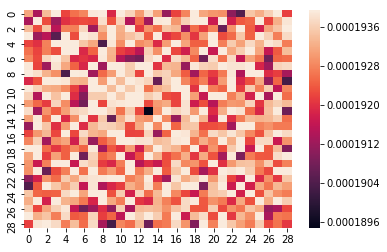

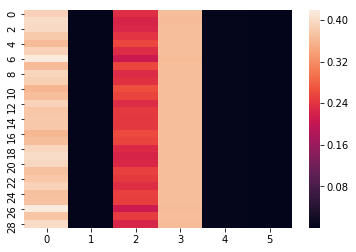

In [125]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(myGen.predict(noise_input)[2][5])
plt.figure()
sn.heatmap(myGen.predict(noise_input)[1][5])

0


RDKit WARNING: Violation occurred on line 167 in file /Users/glandrum/anaconda5/conda-bld/rdkit_1553786961726/work/Code/GraphMol/ROMol.c[20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


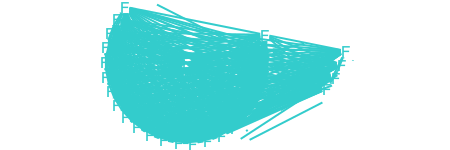

1


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


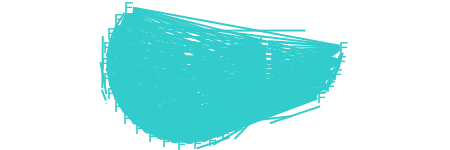

2


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


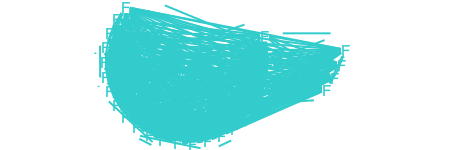

3


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


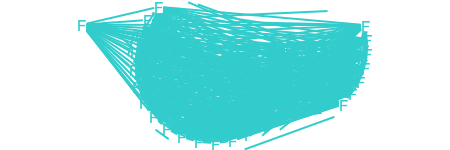

4


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


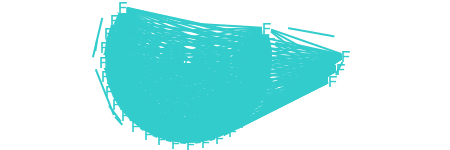

5


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


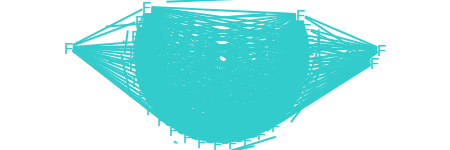

6


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


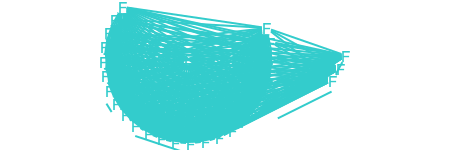

7


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


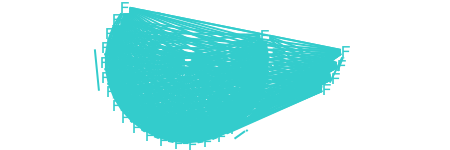

8


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


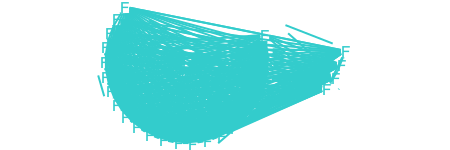

9


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


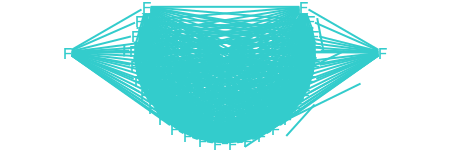

10


RDKit WARNING: [20:37:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


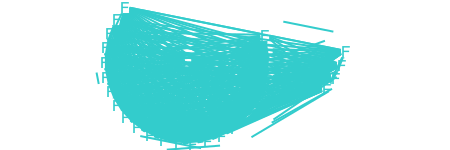

11


RDKit WARNING: [20:37:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


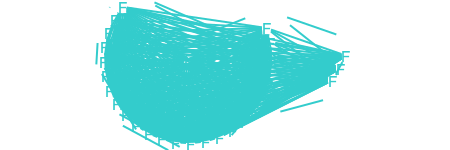

12


RDKit WARNING: [20:37:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


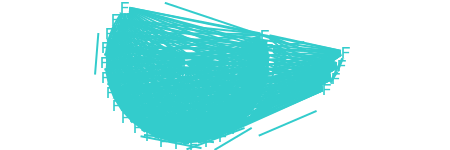

13


RDKit WARNING: [20:37:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


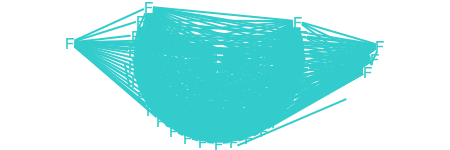

14


RDKit ERROR: pp
RDKit ERROR: Failed Expression: getNumAtoms() > 0
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:37:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 162 in file /Users/glandrum/anaconda5/conda-bld/rdkit_1553786961726/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:37:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 162 in file /Users/glandrum/anaconda5/conda-bld/rdkit_1553786961726/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:37:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: get

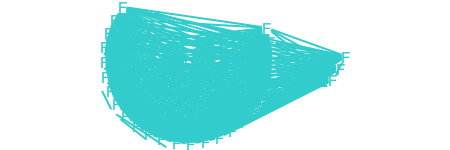

In [118]:
import rdkit.Chem as Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

def fingerprint_to_rdmol(header, bondmat):
    rdmol = Chem.RWMol()
    atoms_29 = []
    staged_atoms = []
    numAtoms = len(header)
    atomDict = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    for i in header:
        staged_atoms += [None]
        if i != 0:
            atoms_29 = atoms_29 + [Chem.Atom(atomDict[i])]
        else:
            atoms_29 = atoms_29 + [None]
    try:
        for j in range(numAtoms):
            for k in range(j+1, numAtoms):
                bondOrder = bondmat[j][k]
                if bondOrder == 7 or bondOrder == 9:
                    #print "delocalized or Pi bond... unhandled"
                    raise ValueError("delocalized or Pi bond... unhandled")
                bondTypes = Chem.rdchem.BondType
                bondOrders = {1:bondTypes.SINGLE, 2:bondTypes.DOUBLE, 3:bondTypes.TRIPLE,
                              4:bondTypes.QUADRUPLE, 5:bondTypes.AROMATIC, 7:bondTypes.AROMATIC, 9:bondTypes.AROMATIC}
                if bondOrder in bondOrders and atoms_29[j] != None and atoms_29[k] != None:
                    if staged_atoms[j] == None:
                        staged_atoms[j] = rdmol.AddAtom(atoms_29[j])
                    if staged_atoms[k] == None:
                        staged_atoms[k] = rdmol.AddAtom(atoms_29[k])
                    rdmol.AddBond(staged_atoms[j], staged_atoms[k], bondOrders[bondOrder])
        return rdmol
    except:
        return None
bondmats, headers, connectivities = myGen.predict(noise_input)

header_idx_to_atom = {np.argmax(j): i for i,j in headers_onehot_dict.items()}
def probabilistic_bondmat(raw_bondmat):
    new_bondmat = np.zeros((raw_bondmat.shape[0], raw_bondmat.shape[1]))
    for i in range(raw_bondmat.shape[0]):
        for j in range(raw_bondmat.shape[1]):
            new_bondmat[i,j] = np.random.choice(range(len(raw_bondmat[i,j,:])), p=raw_bondmat[i,j,:])
    return new_bondmat

headers_reformatted = [[header_idx_to_atom[i] for i in [np.random.choice(range(len(hidden)),p=hidden) for hidden in header]] for header in headers]
bondmats_reformatted = [probabilistic_bondmat(bondmat) for bondmat in bondmats[0:20]]
for i in range(15):
    print(i)
    display(fingerprint_to_rdmol(headers_reformatted[i],bondmats_reformatted[i]))
    

In [73]:
bondmats_reformatted[0]

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [2., 2., 2., 2.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [2., 2., 2., 2.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [39]:
headers_onehot_dict

{0.0: array([1., 0., 0., 0., 0., 0.]),
 1.0: array([0., 1., 0., 0., 0., 0.]),
 6.0: array([0., 0., 1., 0., 0., 0.]),
 7.0: array([0., 0., 0., 1., 0., 0.]),
 8.0: array([0., 0., 0., 0., 1., 0.]),
 9.0: array([0., 0., 0., 0., 0., 1.])}

In [50]:
print 

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

In [49]:
myGen.predict(noise_input)[0][0]

array([[[1.00000000e+00, 2.73614631e-10, 5.88297397e-11, 7.00578706e-09],
        [1.00000000e+00, 5.55830160e-10, 1.54124880e-10, 1.27470843e-08],
        [9.99999881e-01, 5.64572655e-09, 3.40828987e-09, 8.83859812e-08],
        ...,
        [9.99999881e-01, 7.44075557e-09, 4.90451235e-09, 1.11111284e-07],
        [9.99999881e-01, 9.42983380e-09, 6.69756428e-09, 1.35183939e-07],
        [9.99999881e-01, 1.09649934e-08, 8.16439005e-09, 1.53142722e-07]],

       [[1.00000000e+00, 5.55830160e-10, 1.54124880e-10, 1.27470843e-08],
        [1.00000000e+00, 3.99557991e-12, 1.49636244e-13, 1.78148718e-10],
        [9.99999881e-01, 7.21689108e-09, 4.71113903e-09, 1.08335115e-07],
        ...,
        [1.00000000e+00, 1.58719773e-10, 2.78953579e-11, 4.41158932e-09],
        [9.99999881e-01, 3.43174045e-09, 1.76393966e-09, 5.84537823e-08],
        [1.00000000e+00, 1.32056810e-09, 4.94012109e-10, 2.63539732e-08]],

       [[9.99999881e-01, 5.64572655e-09, 3.40828987e-09, 8.83859812e-08],
        

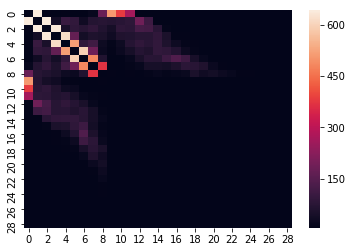

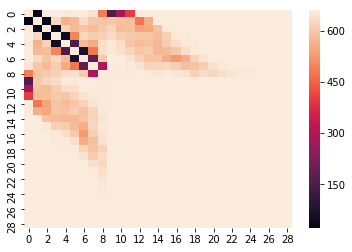

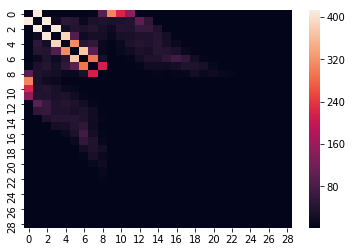

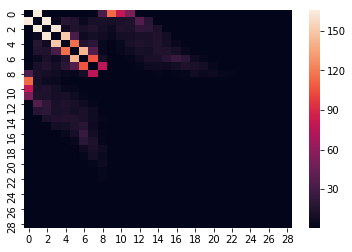

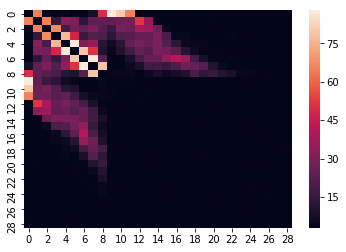

In [67]:
import seaborn as sn
mymodel = myBigModel
sn.heatmap(sum(mymodel.predict(inputs)[0]))
plt.figure()
sn.heatmap(sum(mymodel.predict(inputs)[1])[:,:,0])
plt.figure()
sn.heatmap(sum(mymodel.predict(inputs)[1])[:,:,1])
plt.figure()
sn.heatmap(sum(mymodel.predict(inputs)[1])[:,:,2])
plt.figure()
sn.heatmap(sum(mymodel.predict(inputs)[1])[:,:,3])


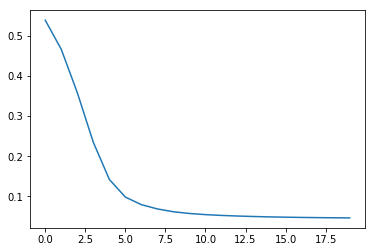

In [119]:
key = next(i for i in history.history.keys() if 'softmax' in i and 'loss' in i)
plt.plot(history.history[key])

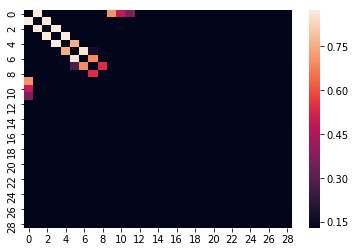

In [16]:
inputs[0]
import seaborn as sn
sn.heatmap(generator.predict([inputs[0]])[0])

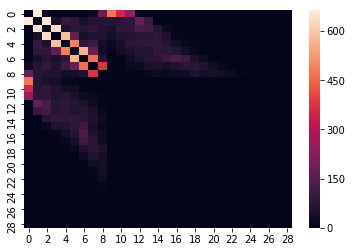

In [18]:
sn.heatmap(sum(connectivities_padded))

In [100]:
print len(matrices)

NameError: name 'matrices' is not defined

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [38]:
# Graph convolution model
# DO NOT CHANGE this code block.

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Need if Conda environment isn't resolved properly
import keras
import sklearn.model_selection
import keras.backend as K

def stacker(tensorList):
    # Stack the bond hidden vectors and atom hidden vectors (29x29x(2*size(atom hidden) + size(bond_hidden)))
    bond_hiddens = tensorList[0]
    atom_hiddens = tensorList[1]
    vertical_atom_hiddens = keras.backend.expand_dims(atom_hiddens,axis=2)
    vertical_atom_hiddens_horizontal = keras.backend.repeat_elements(vertical_atom_hiddens,29,2)
    horiz_atom_hiddens = keras.backend.expand_dims(atom_hiddens,axis=1)
    horiz_atom_hiddens_vertical = keras.backend.repeat_elements(horiz_atom_hiddens,29,1)
    
    big_hidden_boi = keras.backend.concatenate([vertical_atom_hiddens_horizontal, horiz_atom_hiddens_vertical, bond_hiddens], axis=3)
    return big_hidden_boi

def summer(tensorList):
    # Sums the message matrix (29x29x(size(message)))
    messages = tensorList[0]
    connectivity = tensorList[1]
    # Zero out all unconnected messages
    connectivity_expanded = keras.backend.expand_dims(connectivity, axis=3)
    # Add all messages horizontally (29xsize(message))
    filtered = messages*connectivity_expanded # note: * is element-wise, keras.dot is matrix multiplication
    summed_horiz = keras.backend.sum(filtered, axis=2)
    return summed_horiz

def image_categorical_crossentropy(y_true, y_pred):
    # Boilerplate off the internet to do crossentropy for multi-classification tasks,
    # in this case assigning one-hot atom labels to atoms
    __EPS = 1e-5
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

def generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=False,\
                      message_dense_resize=None, atom_dense_resize=None, do_readout = False):
    bond_hiddens_input = keras.layers.Input(shape=(num_nodes,num_nodes,bond_hidden_length))
    atom_hiddens_input = keras.layers.Input(shape=(num_nodes,atom_hidden_length))
    connectivity_input = keras.layers.Input(shape=(num_nodes,num_nodes))
    
    # For JP's task
    if hide_atoms:
        atom_hiddens = keras.layers.Lambda(lambda x: x*0.0)(atom_hiddens_input) # For JP's exercise - eliminate atom info.
    else:
        atom_hiddens = atom_hiddens_input
    
    message_stack = keras.layers.Lambda(stacker)([bond_hiddens_input, atom_hiddens])
    
    # Should we dense the total hidden vector?
    if message_dense_resize != None:
        messages = keras.layers.Dense(message_dense_resize, activation='relu')(message_stack)
    else:
        messages = message_stack
    
    message_sum = keras.layers.Lambda(summer)([messages, connectivity_input])
    
    # Should we dense the atom hidden vector?
    if atom_dense_resize != None:
        message_interpret = keras.layers.Dense(atom_dense_resize, activation='relu')(message_sum)
    else:
        message_interpret = message_sum
    
    if do_readout:
        raise ValueError('Not supported yet.')
    else:
        message_to_onehot = keras.layers.Dense(atom_hidden_length, activation='softmax')(message_interpret)
        model = keras.models.Model(inputs=[bond_hiddens_input, atom_hiddens_input, connectivity_input], outputs=[bond_hiddens_input, message_to_onehot, connectivity_input])
        return model
'''
bond_hiddens_input = keras.layers.Input(shape=(29,29,4)) # For now, has the same dimension as bond feature vector
atom_hiddens_input = keras.layers.Input(shape=(29,6)) # For now, has the same dimension as atom feature vector
atom_hiddens_zeroed = keras.layers.Lambda(lambda x: x*0.0)(atom_hiddens_input) # For JP's exercise - eliminate atom info.
connectivity_input = keras.layers.Input(shape=(29,29))

message_stack = keras.layers.Lambda(stacker)([bond_hiddens_input, atom_hiddens_zeroed])

# You can use an NN on all 29*29 concatenated hidden vectors
#messages = keras.layers.Dense(30, activation='relu')(message_stack)

message_sum = keras.layers.Lambda(summer)([message_stack, connectivity_input])

# You can use an NN on all 29 messages (each message is a sum of incoming messages)
message_interpret = keras.layers.Dense(6, activation='tanh')(message_sum)

# Read out the atom identities
message_to_onehot = keras.layers.Dense(6, activation='softmax')(message_interpret)

model = keras.models.Model(inputs=[bond_hiddens_input, atom_hiddens_input, connectivity_input], outputs=message_to_onehot)

model.compile(optimizer='adam',
              loss=image_categorical_crossentropy,
              metrics=['mean_squared_error', 'mean_absolute_error','categorical_crossentropy'])
'''

num_nodes = 29
bond_hidden_length = 4
atom_hidden_length = 6

bond_hiddens_input = keras.layers.Input(shape=(num_nodes,num_nodes,bond_hidden_length))
atom_hiddens_input = keras.layers.Input(shape=(num_nodes,atom_hidden_length))
connectivity_input = keras.layers.Input(shape=(num_nodes,num_nodes))

gcModel = generate_gc_model(num_nodes=29, atom_hidden_length=6, bond_hidden_length=4, hide_atoms=True,\
                    message_dense_resize=None, atom_dense_resize=100, do_readout = False)

post_gc = gcModel([bond_hiddens_input, atom_hiddens_input, connectivity_input])

biggerModel = keras.models.Model(inputs=[bond_hiddens_input, atom_hiddens_input, connectivity_input], outputs=post_gc[1])
biggerModel.compile(optimizer='adam',
              loss=image_categorical_crossentropy,
              metrics=['mean_squared_error', 'mean_absolute_error','categorical_crossentropy'])

inputObjects = [[matrix, header, connectivity] for matrix, header, connectivity in zip(matrices_padded, headers_padded, connectivities_padded)]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputObjects, headers_padded, test_size=0.33)

biggerModel.fit(map(list,zip(*X_train)), y_train, epochs=30, verbose=True)

Epoch 1/30


KeyboardInterrupt: 

In [37]:
len(map(list,zip(*X_train))[0])

445

array([[2745,    0,    0,    0,    0,    0],
       [   0, 1755,    0,    0,    0,    0],
       [   0,    0, 1257,    4,    0,    0],
       [   0,   15,  132,  117,    2,    0],
       [   0,  212,    0,    0,  128,    0],
       [   0,   13,    0,    0,    0,    0]])

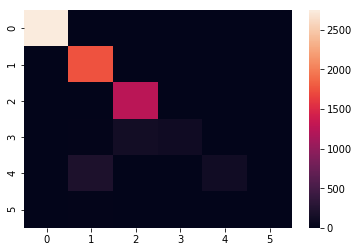

In [40]:
# Print confusion matrix

import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn

y_pred = np.ndarray.flatten(np.argmax(biggerModel.predict(map(list,zip(*X_test))), axis=2))
y_true = np.ndarray.flatten(np.argmax(y_test, axis=2))
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred).astype(float)
normalize_confusion = confusion/np.array([np.sum(confusion,axis=1)]).T
sn.heatmap(confusion)
display(confusion.astype(int))

In [241]:
model.count_params()

144

In [ ]:
# Everything after this is trash lol

In [208]:
header_vec = np.zeros(headers_padded[0].shape)
connectivity_graph = connectivities_padded[0]
bondmat = matrices_padded[0]

horiz_repeat = np.repeat(np.expand_dims(header_vec, axis=1), 29, axis=1)
vert_repeat = np.repeat(np.expand_dims(header_vec, axis=0), 29, axis=0)
combined = np.concatenate([horiz_repeat, vert_repeat,bondmat],axis=2)
mystates = np.sum(combined * np.expand_dims(connectivity_graph, axis=2), axis=1)
print (mystates[:,-3]+2*mystates[:,-2]+3*mystates[:,-1]).astype(int)
print np.argmax(headers_padded[0], axis=1)

[2 4 4 2 4 2 4 4 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 2 2 4 2 4 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


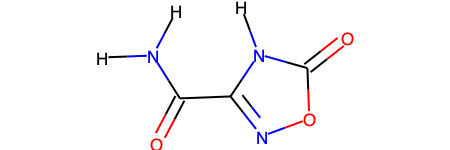

In [205]:
import rdkit.Chem as Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

def fingerprint_to_rdmol(header, bondmat):
    rdmol = Chem.RWMol()
    indices = []
    numAtoms = len(header)
    atomDict = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    for i in header:
        if i != 0:
            indices = indices + [rdmol.AddAtom(Chem.Atom(atomDict[i]))]
    for j in range(numAtoms):
        for k in range(j, numAtoms):
            bondOrder = bondmat[j][k]
            if bondOrder == 7 or bondOrder == 9:
                #print "delocalized or Pi bond... unhandled"
                raise ValueError("delocalized or Pi bond... unhandled")
            bondTypes = Chem.rdchem.BondType
            bondOrders = {1:bondTypes.SINGLE, 2:bondTypes.DOUBLE, 3:bondTypes.TRIPLE,
                          4:bondTypes.QUADRUPLE, 5:bondTypes.AROMATIC, 7:bondTypes.AROMATIC, 9:bondTypes.AROMATIC}
            if bondOrder in bondOrders:
                rdmol.AddBond(indices[j], indices[k], bondOrders[bondOrder])
    return rdmol
fingerprint_to_rdmol(origHeaders_padded[4],origMatrices_padded[4])

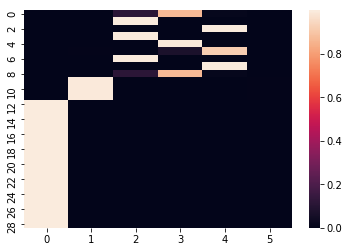

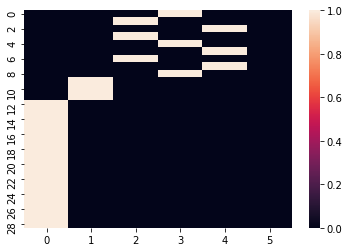

In [212]:
sampleNum = 4
prediction = model.predict([matrices_padded[sampleNum:sampleNum+1], headers_padded[sampleNum:sampleNum+1], connectivities_padded[sampleNum:sampleNum+1]])
sn.heatmap(prediction[0])
plt.figure()
sn.heatmap(headers_padded[sampleNum])

In [243]:
# How good is a "dumb" fully-connected network followed by softmax? Pretty good, it seems...


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(matrices_padded, headers_padded, test_size=0.33)

inputLayer = keras.layers.Input(shape=(29,29,4))
flattenLayer = keras.layers.Flatten()(inputLayer)
denseLayer = keras.layers.Dense(29*6,activation='relu')(flattenLayer)
reshapeLayer = keras.layers.Reshape((29,6))(denseLayer)
choiceLayer = keras.layers.Softmax(axis=2)(reshapeLayer)


model = keras.models.Model(inputs=inputLayer, outputs=choiceLayer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['mean_squared_error', 'mean_absolute_error','categorical_crossentropy'])
print model.count_params()
model.fit(X_train, y_train, epochs=300, verbose=True)



585510
Epoch 1/300


KeyboardInterrupt: 

array([[2596,   32,    0,    0,    0,    0],
       [ 137, 1712,    4,    0,    0,    0],
       [ 485,    1,  807,    8,    0,    0],
       [ 127,    6,   77,   14,   16,    0],
       [ 230,   11,   35,   15,   54,    0],
       [  10,    1,    0,    1,    1,    0]])

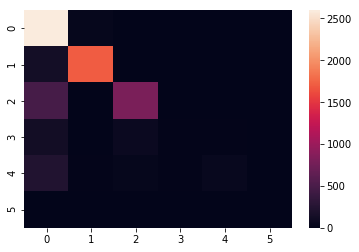

In [214]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn

y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test), axis=2))
y_true = np.ndarray.flatten(np.argmax(y_test, axis=2))
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred).astype(float)
normalize_confusion = confusion/np.array([np.sum(confusion,axis=1)]).T
sn.heatmap(confusion)
display(confusion.astype(int))

array([[8001,  204,    1,    0,    0,    0],
       [2445, 2884,   26,    0,    1,    0],
       [ 477,    1, 3333,    9,    2,    0],
       [ 131,   13,  505,   58,   98,    0],
       [ 239,    2,  244,   13,  567,    0],
       [   8,    0,    6,    0,   17,    0]])

In [190]:
array_cohort = [np.zeros((np.random.randint(5),np.random.randint(5))) for _ in range(200)]


[4, 4]

In [6]:
# A working predictor for ONE graph. Protect this. It works.
# MASTER VERSION.

import os, sys, glob
import numpy as np
import scipy as sp
import copy
import keras

import itertools as it

def readfile(fname):
    def prune(vec, mat, maxsize=15):
        if len(vec) < maxsize:
            old_length = len(vec)
            vec = np.pad(vec, (0, maxsize-old_length), 'constant')
            mat = np.pad(mat, ((0, maxsize-old_length), (0, maxsize-old_length)), 'constant')
            assert len(vec) == maxsize, 'Length of vector not equal to max size - this is an implementation error.'
            assert mat.shape == (maxsize, maxsize), 'Size of matrix not equal to max size - this is an implementation error.'
        assert all([i<maxsize for i,j in enumerate(vec) if j!=0]), 'Vector has nonzero entries after element 15!'
        if len(vec) > maxsize:
            assert np.all(mat.T == mat), 'Matrix is not symmetric - case not handled!'
            assert all(np.any(mat[maxsize:] != 0, 0) == False), 'Some nonzero horizontal rows found outside cutoff!'
        return (vec[:maxsize], mat[:maxsize, :maxsize])

    a = open(fname)
    b = a.readlines()
    a.close()
    csv_as_float_2D = [map(float,i.strip().split(',')) for i in b]
    atom_list = csv_as_float_2D[0]
    bond_orders = csv_as_float_2D[1:]

    atom_vec = np.array(atom_list)
    BO_mat = np.array(bond_orders)
    assert len(np.shape(atom_vec))==1, 'Atom vector is not a flat array!'
    assert np.shape(atom_vec)[0] == np.shape(BO_mat)[0], "Dimensions of atom vector and bond order matrix don't match!"
    assert np.all(BO_mat.T == BO_mat), 'Bond order matrix is not symmetric!'
    try:
        return prune(atom_vec, BO_mat, 29)
    except AssertionError as e:
        print(g)
        print(BO_mat.shape)
        print(e.args)
        return None

def takeFirst(x):
    return x[0]

def separateMe(x):
    guess = x[:,-1:]
    mymatrix = x[:,:-1]
    
    guess_is = keras.backend.repeat_elements(guess,29,1)
    guess_js = keras.backend.repeat_elements(keras.backend.transpose(guess),29,0)
    #edges = keras.backend.cast_to_floatx(mymatrix)
    edges = mymatrix
    bigmat = keras.backend.stack((guess_is, guess_js, edges),2)
    return [guess, mymatrix, bigmat]

def refactorizer(operated):
    new_1d = keras.backend.transpose(keras.backend.sum(operated,1))
    #new_1d = keras.backend.expand_dims(new_1d,axis=0)
    return new_1d

graphlist = glob.glob('qm9graph/*.csv')
vecs_and_matrices = [readfile(g) for g in graphlist]
vecs = [i for i,j in vecs_and_matrices]
matrices = [j for i,j in vecs_and_matrices]

TakeFirst = keras.layers.Lambda(takeFirst)
Separator = keras.layers.Lambda(separateMe)
Refactorizer = keras.layers.Lambda(refactorizer)

inputs = keras.layers.Input(shape=(29,30,), batch_shape=(None,29,30))
firstinput = TakeFirst(inputs)
myvec, mygraph, bigmat = Separator(firstinput)

# M kernel - automatically detects that the input has dimension 3
redonemat = keras.layers.Dense(1)(keras.layers.Dense(3, activation='tanh')(bigmat))

newhidden = Refactorizer(redonemat)

combined_thing_y = np.expand_dims(vecs[0],axis=1)
combined_thing = np.concatenate((matrices[0], combined_thing_y), axis=1)
combined_thing = np.array([combined_thing])

model = keras.models.Model(inputs=inputs, outputs=newhidden)
model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])
model.fit(combined_thing, np.expand_dims(vecs[0], axis=0), epochs=250, batch_size=1)

Epoch 1/250
1/1 [==============================] - 1s 673ms/step - loss: 90.4713 - mean_squared_error: 90.4713 - mean_absolute_error: 8.8135
Epoch 2/250
1/1 [==============================] - 0s 3ms/step - loss: 76.2980 - mean_squared_error: 76.2980 - mean_absolute_error: 8.0571
Epoch 3/250
1/1 [==============================] - 0s 3ms/step - loss: 67.5285 - mean_squared_error: 67.5285 - mean_absolute_error: 7.5781
Epoch 4/250
1/1 [==============================] - 0s 3ms/step - loss: 61.0061 - mean_squared_error: 61.0061 - mean_absolute_error: 7.2016
Epoch 5/250
1/1 [==============================] - 0s 2ms/step - loss: 55.7775 - mean_squared_error: 55.7775 - mean_absolute_error: 6.8856
Epoch 6/250
1/1 [==============================] - 0s 2ms/step - loss: 51.4083 - mean_squared_error: 51.4083 - mean_absolute_error: 6.6101
Epoch 7/250
1/1 [==============================] - 0s 2ms/step - loss: 47.6589 - mean_squared_error: 47.6589 - mean_absolute_error: 6.3641
Epoch 8/250
1/1 [========

Epoch 60/250
1/1 [==============================] - 0s 3ms/step - loss: 3.9639 - mean_squared_error: 3.9639 - mean_absolute_error: 1.7657
Epoch 61/250
1/1 [==============================] - 0s 2ms/step - loss: 3.8105 - mean_squared_error: 3.8105 - mean_absolute_error: 1.7290
Epoch 62/250
1/1 [==============================] - 0s 2ms/step - loss: 3.6634 - mean_squared_error: 3.6634 - mean_absolute_error: 1.6931
Epoch 63/250
1/1 [==============================] - 0s 2ms/step - loss: 3.5223 - mean_squared_error: 3.5223 - mean_absolute_error: 1.6580
Epoch 64/250
1/1 [==============================] - 0s 3ms/step - loss: 3.3871 - mean_squared_error: 3.3871 - mean_absolute_error: 1.6237
Epoch 65/250
1/1 [==============================] - 0s 3ms/step - loss: 3.2574 - mean_squared_error: 3.2574 - mean_absolute_error: 1.5901
Epoch 66/250
1/1 [==============================] - 0s 3ms/step - loss: 3.1330 - mean_squared_error: 3.1330 - mean_absolute_error: 1.5573
Epoch 67/250
1/1 [================

Epoch 120/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4567 - mean_squared_error: 0.4567 - mean_absolute_error: 0.5166
Epoch 121/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4426 - mean_squared_error: 0.4426 - mean_absolute_error: 0.5078
Epoch 122/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4290 - mean_squared_error: 0.4290 - mean_absolute_error: 0.4992
Epoch 123/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4159 - mean_squared_error: 0.4159 - mean_absolute_error: 0.4907
Epoch 124/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4034 - mean_squared_error: 0.4034 - mean_absolute_error: 0.4827
Epoch 125/250
1/1 [==============================] - 0s 3ms/step - loss: 0.3912 - mean_squared_error: 0.3912 - mean_absolute_error: 0.4751
Epoch 126/250
1/1 [==============================] - 0s 3ms/step - loss: 0.3796 - mean_squared_error: 0.3796 - mean_absolute_error: 0.4676
Epoch 127/250
1/1 [========

Epoch 179/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1106 - mean_squared_error: 0.1106 - mean_absolute_error: 0.2359
Epoch 180/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2333
Epoch 181/250
1/1 [==============================] - 0s 3ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - mean_absolute_error: 0.2308
Epoch 182/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1054 - mean_squared_error: 0.1054 - mean_absolute_error: 0.2283
Epoch 183/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1038 - mean_squared_error: 0.1038 - mean_absolute_error: 0.2259
Epoch 184/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2235
Epoch 185/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2211
Epoch 186/250
1/1 [========

Epoch 238/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1385
Epoch 239/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1375
Epoch 240/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.1365
Epoch 241/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - mean_absolute_error: 0.1355
Epoch 242/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1346
Epoch 243/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0553 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1337
Epoch 244/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1327
Epoch 245/250
1/1 [========

In [9]:
combined_thing_y

array([[[8.],
        [6.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [6.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

In [406]:
print(model.predict(combined_thing))
print(model.get_weights())
np.mean(np.abs(model.predict(combined_thing) - np.expand_dims(vecs[0], axis=0)))

[[ 8.799278    5.6296477   5.6296477   8.7966585   5.031527    8.78908
   5.2160206   5.361666    1.3293701   1.3790778   1.3790777   1.3790778
  -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637
  -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637
  -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637]]
[array([[ 0.7604049 , -1.0607893 , -0.7237089 ],
       [-0.35061258,  0.8058956 ,  0.14019883],
       [-0.41346732,  0.7028782 ,  0.41891006]], dtype=float32), array([ 0.09325026, -0.12081977,  0.03234083], dtype=float32), array([[ 0.42809203],
       [-0.741643  ],
       [ 0.9459558 ]], dtype=float32), array([0.08198211], dtype=float32)]


0.2875213396960291

In [256]:
def reshapeMe(x):
        x = x[0] # Take the first element of x, ignore everything else.
        guess = x[:,-1:]
        mymatrix = x[:,:-1]
        mpassfunc = self.mpassfunc
        self._trainable_weights.append(mpassfunc.trainable_weights)
        #guess, mymatrix, mpassfunc = x # guess refers to the hidden message vector
        guess_is = keras.backend.repeat_elements(guess,29,1)
        guess_js = keras.backend.repeat_elements(keras.backend.transpose(guess),29,0)
        #edges = keras.backend.cast_to_floatx(mymatrix)
        edges = mymatrix
        bigmat = keras.backend.stack((guess_is, guess_js, edges),2)
        operated = mpassfunc(bigmat)
        new_2d = keras.backend.batch_flatten(operated)
        new_1d = keras.backend.sum(new_2d,1)
        
        final_return = keras.backend.concatenate((new_2d, keras.backend.expand_dims(new_1d,axis=1)), axis=1)
        return keras.backend.expand_dims(final_return[:,-1:],axis=0)

    def compute_output_shape(self, input_shape):
        return (None, 29, 1)

AttributeError: 'Sequential' object has no attribute 'kernel'

In [211]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(3, input_shape=(1,)))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
#model.fit([1,2,3,200,1,-4],[1,1,1,1,1,1], epochs=5)
#model.fit([1],[1], epochs=5)
model.predict([1,10,2,20])

array([[0.3228463],
       [3.2284632],
       [0.6456926],
       [6.4569263]], dtype=float32)

In [151]:
a = np.zeros((3,1))
g = np.ones((3,4))
g[:,3] = 2
g[:,-1:]
g[:,:-1]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
# Bad attempt at graph convolution
import os, sys, glob
import numpy as np
import scipy as sp
import copy
import keras

import itertools as it

graphlist = glob.glob('qm9graph/*.csv')
vecs_and_matrices = [readfile(g) for g in graphlist]
vecs = [i for i,j in vecs_and_matrices]
matrices = [j for i,j in vecs_and_matrices]

def readfile(fname):
    a = open(fname)
    b = a.readlines()
    a.close()
    csv_as_float_2D = [map(float,i.strip().split(',')) for i in b]
    atom_list = csv_as_float_2D[0]
    bond_orders = csv_as_float_2D[1:]

    atom_vec = np.array(atom_list)
    BO_mat = np.array(bond_orders)
    assert len(np.shape(atom_vec))==1, 'Atom vector is not a flat array!'
    assert np.shape(atom_vec)[0] == np.shape(BO_mat)[0], "Dimensions of atom vector and bond order matrix don't match!"
    assert np.all(BO_mat.T == BO_mat), 'Bond order matrix is not symmetric!'
    try:
        return prune(atom_vec, BO_mat, 29)
    except AssertionError as e:
        print(g)
        print(BO_mat.shape)
        print(e.args)
        return None

def prune(vec, mat, maxsize=15):
    if len(vec) < maxsize:
        old_length = len(vec)
        vec = np.pad(vec, (0, maxsize-old_length), 'constant')
        mat = np.pad(mat, ((0, maxsize-old_length), (0, maxsize-old_length)), 'constant')
        assert len(vec) == maxsize, 'Length of vector not equal to max size - this is an implementation error.'
        assert mat.shape == (maxsize, maxsize), 'Size of matrix not equal to max size - this is an implementation error.'
    assert all([i<maxsize for i,j in enumerate(vec[0]) if j!=0]), 'Vector has nonzero entries after element 15!'
    if len(vec) > maxsize:
        assert np.all(mat.T == mat), 'Matrix is not symmetric - case not handled!'
        assert all(np.any(mat[maxsize:] != 0, 0) == False), 'Some nonzero horizontal rows found outside cutoff!'
    return (vec[:maxsize], mat[:maxsize, :maxsize])


class Messenger(keras.layers.Layer):
    # Performs message passing with the same M kernel once, without postprocessing. Includes passing to self.
    def __init__(self, mpassfunc, **kwargs):
        #self.mpassfunc = mpassfunc
        self.mpassfunc = mpassfunc
        super(Messenger, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Messenger, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x)
        print(x[0])
        print(x.shape)
        x = x[0] # Take the first element of x, ignore everything else.
        guess = x[:,-1:]
        mymatrix = x[:,:-1]
        mpassfunc = self.mpassfunc
        self._trainable_weights.append(mpassfunc.trainable_weights)
        #guess, mymatrix, mpassfunc = x # guess refers to the hidden message vector
        guess_is = keras.backend.repeat_elements(guess,29,1)
        guess_js = keras.backend.repeat_elements(keras.backend.transpose(guess),29,0)
        #edges = keras.backend.cast_to_floatx(mymatrix)
        edges = mymatrix
        bigmat = keras.backend.stack((guess_is, guess_js, edges),2)
        operated = mpassfunc(bigmat)
        new_2d = keras.backend.batch_flatten(operated)
        new_1d = keras.backend.sum(new_2d,1)
        
        final_return = keras.backend.concatenate((new_2d, keras.backend.expand_dims(new_1d,axis=1)), axis=1)
        return keras.backend.expand_dims(final_return[:,-1:],axis=0)

    def compute_output_shape(self, input_shape):
        return (None, 29, 1)
    


    
labelator = keras.models.Sequential()
labelator.add(keras.layers.Dense(3, input_shape=(3,)))
labelator.add(keras.layers.Dense(1))
labelator.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

inputs = keras.layers.Input(shape=(29,30,))
b = Messenger(mpassfunc=labelator)(inputs)

#b = Messenger()(a)

model = keras.models.Model(inputs=inputs, outputs=b)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

combined_thing_y = np.expand_dims(vecs[0],axis=1)
combined_thing = np.concatenate((matrices[0], combined_thing_y), axis=1)
combined_thing = np.array([combined_thing])
combined_thing_y = np.expand_dims(combined_thing_y, axis=0)

print(combined_thing.shape)
model.fit(combined_thing, combined_thing_y, epochs=5)